## Importing Libraries

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model


## Data Loading

#### Train Data

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
csv_file = "/content/driving_log.csv"
data = pd.read_csv(csv_file, names=['photo names', 'sterring', 'throttle'])
print(data.head(15))

                           photo names      sterring  throttle
0                               center      steering  throttle
1   center_2023_12_05_15_07_11_139.jpg             0         0
2   center_2023_12_05_15_07_11_249.jpg             0         0
3   center_2023_12_05_15_07_11_360.jpg             0         0
4   center_2023_12_05_15_07_11_473.jpg             0         0
5   center_2023_12_05_15_07_11_582.jpg             0         0
6   center_2023_12_05_15_07_11_694.jpg             0         0
7   center_2023_12_05_15_07_11_806.jpg             0         0
8   center_2023_12_05_15_07_11_924.jpg             0         0
9   center_2023_12_05_15_07_12_032.jpg    -0.1880279         0
10  center_2023_12_05_15_07_12_142.jpg     -0.518598         0
11  center_2023_12_05_15_07_12_256.jpg    -0.6715319         0
12  center_2023_12_05_15_07_12_370.jpg    -0.3316437         0
13  center_2023_12_05_15_07_12_478.jpg  -0.005600452         0
14  center_2023_12_05_15_07_12_590.jpg    -0.1850578   

In [120]:
images_dir='/content/drive/MyDrive/IMG (1)'

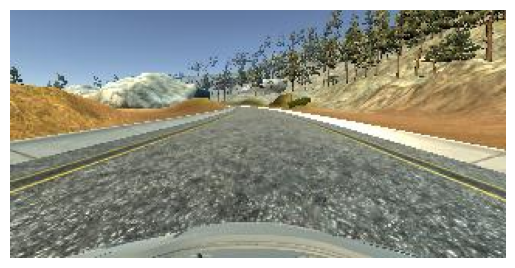

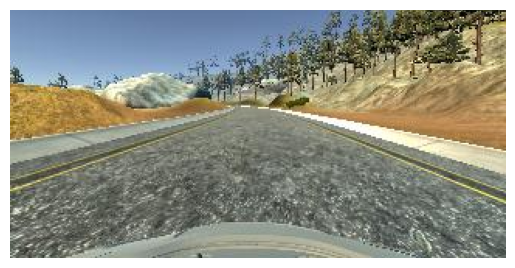

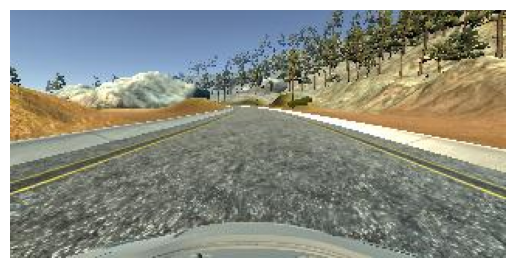

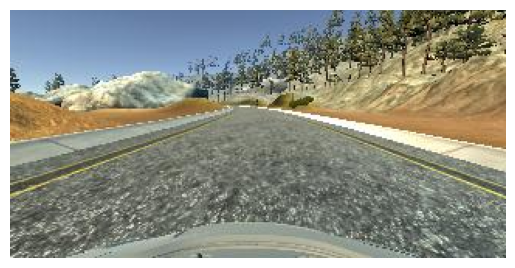

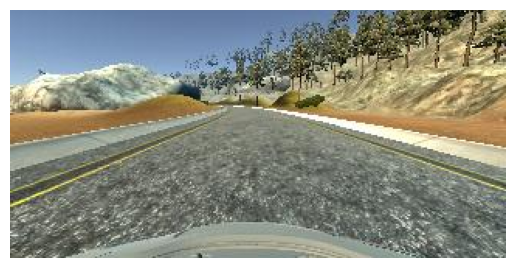

In [71]:
image_files = os.listdir(images_dir)

for i in range(5):
    img = cv2.imread(os.path.join(images_dir, image_files[i]))

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

#### Test Data

In [194]:
csv_file = "/content/Testdriving_log.csv"
dataTest = pd.read_csv(csv_file, names=['photo names', 'sterring', 'throttle'])
print(dataTest.head(15))

                           photo names  sterring  throttle
0   center_2023_12_05_22_27_47_304.jpg  0.000000  0.000000
1   center_2023_12_05_22_27_47_414.jpg  0.000000  0.000000
2   center_2023_12_05_22_27_47_521.jpg  0.000000  0.000000
3   center_2023_12_05_22_27_47_626.jpg  0.000000  0.000000
4   center_2023_12_05_22_27_47_731.jpg  0.000000  0.000000
5   center_2023_12_05_22_27_47_836.jpg  0.000000  0.000000
6   center_2023_12_05_22_27_47_944.jpg  0.000000  0.000000
7   center_2023_12_05_22_27_48_050.jpg  0.000000  0.000000
8   center_2023_12_05_22_27_48_181.jpg  0.000000  0.332121
9   center_2023_12_05_22_27_48_288.jpg  0.000000  0.652215
10  center_2023_12_05_22_27_48_395.jpg  0.000000  0.972072
11  center_2023_12_05_22_27_48_481.jpg  0.000000  0.650820
12  center_2023_12_05_22_27_48_588.jpg  0.000000  0.330738
13  center_2023_12_05_22_27_48_695.jpg -0.321039  0.009699
14  center_2023_12_05_22_27_48_803.jpg -0.254922  0.000000


In [195]:
test_dir='/content/drive/MyDrive/TestIMG'

## Data Preparing

#### Train Data

In [121]:
filenames = data['photo names'].tolist()
steering_labels = data['sterring'].tolist()
throttle_labels = data['throttle'].tolist()

images = []
steering = []
throttle = []

In [122]:
for filename, steering_label, throttle_label in zip(filenames, steering_labels, throttle_labels):
    img_path = os.path.join(images_dir, filename)
    img = cv2.imread(img_path)
    if img is not None:  # Check if the image is properly loaded
        images.append(img)
        steering.append(steering_label)
        throttle.append(throttle_label)

In [123]:
X = np.array(images)
y_steering = np.array(steering)
y_throttle = np.array(throttle)

In [124]:
X.shape

(1269, 160, 320, 3)

In [125]:
resized_images = []
desired_size = (224, 224)

for img in X:
    resized = cv2.resize(img, desired_size, interpolation=cv2.INTER_AREA)
    resized_images.append(resized)

X = np.array(resized_images)

In [126]:
X.shape

(1269, 224, 224, 3)

In [127]:
y_steering.shape

(1269,)

In [128]:
y_throttle.shape

(1269,)

In [133]:
X_resized = X.astype(np.float32)
y_steering = y_steering.astype(np.float32)
y_throttle = y_throttle.astype(np.float32)

In [134]:
y_combined = np.stack((y_steering, y_throttle), axis=1)

#### Test Data

In [196]:
filenames = dataTest['photo names'].tolist()
steering_labels = dataTest['sterring'].tolist()
throttle_labels = dataTest['throttle'].tolist()

images = []
steering = []
throttle = []

In [197]:
for filename, steering_label, throttle_label in zip(filenames, steering_labels, throttle_labels):
    img_path = os.path.join(test_dir, filename)
    img = cv2.imread(img_path)
    if img is not None:  # Check if the image is properly loaded
        images.append(img)
        steering.append(steering_label)
        throttle.append(throttle_label)

In [198]:
X_test = np.array(images)
y_steering_test = np.array(steering)
y_throttle_test = np.array(throttle)

In [199]:
resized_images = []
desired_size = (224, 224)

for img in X_test:
    resized = cv2.resize(img, desired_size, interpolation=cv2.INTER_AREA)
    resized_images.append(resized)

X_test = np.array(resized_images)

In [200]:
X_test.shape

(166, 224, 224, 3)

In [201]:
y_steering_test.shape

(166,)

In [202]:
X_test = X_test.astype(np.float32)
y_steering_test = y_steering_test.astype(np.float32)
y_throttle_test = y_throttle_test.astype(np.float32)

In [203]:
y_combined_test= np.stack((y_steering_test, y_throttle_test), axis=1)

In [204]:
y_combined_test.shape

(166, 2)

## Modeling [ MobileNetV2 Tensorflow keras ]

In [131]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add custom regression layers for two outputs
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(2, name='output')(x)  # 2 units for steering and throttle

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with appropriate loss function and optimizer for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Use appropriate metrics and optimizer


9406464/9406464 [==============================] - 0s 0us/step


In [135]:
history = model.fit(
    X, y_combined,
    epochs=10,
    validation_split=0.2,
    batch_size=32
)

Epoch 1/10
32/32 [==============================] - 64s 2s/step - loss: 0.9980 - mae: 0.5212 - val_loss: 0.1132 - val_mae: 0.2406
Epoch 2/10
32/32 [==============================] - 61s 2s/step - loss: 0.0949 - mae: 0.2205 - val_loss: 0.1046 - val_mae: 0.2436
Epoch 3/10
32/32 [==============================] - 50s 2s/step - loss: 0.0894 - mae: 0.2171 - val_loss: 0.1204 - val_mae: 0.2721
Epoch 4/10
32/32 [==============================] - 48s 1s/step - loss: 0.0957 - mae: 0.2240 - val_loss: 0.1393 - val_mae: 0.3105
Epoch 5/10
32/32 [==============================] - 52s 2s/step - loss: 0.0845 - mae: 0.2106 - val_loss: 0.1032 - val_mae: 0.2287
Epoch 6/10
32/32 [==============================] - 51s 2s/step - loss: 0.0781 - mae: 0.2039 - val_loss: 0.1057 - val_mae: 0.2583
Epoch 7/10
32/32 [==============================] - 59s 2s/step - loss: 0.0757 - mae: 0.1992 - val_loss: 0.1053 - val_mae: 0.2422
Epoch 8/10
32/32 [==============================] - 50s 2s/step - loss: 0.0777 - mae: 0.20

## Modeling PyTorch

In [137]:
X_tensor = torch.tensor(X )
Y_tensor = torch.tensor(y_combined)

dataset = TensorDataset(X_tensor, Y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [149]:
for inputs, targets in train_loader:
    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([32, 224, 224, 3])
torch.Size([32, 2])


#### Build and Train The Model

In [162]:
class CarModel(nn.Module):
    def __init__(self):
        super(CarModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [169]:
model = CarModel()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs= inputs.to(torch.float)
        inputs= inputs.permute(0, 3, 1, 2)
        inputs = inputs.contiguous()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs= inputs.to(torch.float)
            inputs= inputs.permute(0, 3, 1, 2)
            inputs = inputs.contiguous()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Val Loss: {val_loss:.4f}")


Epoch [1/10] Train Loss: 58836.2256 Val Loss: 0.6421
Epoch [2/10] Train Loss: 1.0013 Val Loss: 0.1363
Epoch [3/10] Train Loss: 0.1660 Val Loss: 0.1182
Epoch [4/10] Train Loss: 0.1065 Val Loss: 0.1052
Epoch [5/10] Train Loss: 0.0843 Val Loss: 0.0870
Epoch [6/10] Train Loss: 0.0702 Val Loss: 0.0884
Epoch [7/10] Train Loss: 0.0618 Val Loss: 0.0846
Epoch [8/10] Train Loss: 0.0549 Val Loss: 0.0723
Epoch [9/10] Train Loss: 0.0470 Val Loss: 0.0655
Epoch [10/10] Train Loss: 0.0423 Val Loss: 0.0639


#### Test Evaluation

In [205]:
X_tensor = torch.tensor(X_test )
Y_tensor = torch.tensor(y_combined_test)

dataset_test = TensorDataset(X_tensor, Y_tensor)

test_loader = DataLoader(dataset_test, batch_size=batch_size)

In [213]:
model.eval()

test_loss = 0.0
total_samples = 0

criterion = torch.nn.MSELoss()  \

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs= inputs.permute(0, 3, 1, 2)
        inputs = inputs.contiguous()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

average_loss = test_loss / total_samples

print(f"Test Mean Squared Error (MSE): {average_loss:.4f}")


Test Mean Squared Error (MSE): 0.0934


In [214]:
%matplotlib inline